# In-hospital length of stay

Prediction of hospitaliztion length of stay (LOS), can be a proxy to patients illness severity, and can be considered as a possible risk stratification model - the longer a patient is expected to be hospitalized, the more severe his status, and he may be prone to complications. In addition, longer stay costs money, increases the burden on the healthcare system and on the medical staff. Prediction of the expected LOS on the first day of hospitalization, can help with managing the available resources.

In this example, we simulate a dataset of 10,000 hospitalized patietns and estimate the model as described in Usage Example section. 

We sample the covariates such that:

$\mbox{Admission Year} \sim \mbox{Uniform}(2000,2014)$

$\mbox{Gender} \sim \mbox{Bernoullie}(0.5), \qquad$ (1 is Female, 0 is Male)

$\mbox{Age} \sim \mbox{Normal}(72+5*\mbox{gender}\;,\;12)$ (years)

$\mbox{Height} \sim \mbox{Normal}(175-5*\mbox{gender}\;,\;7)$ (cm) 

$\mbox{Weight} \sim \mbox{Normal}(\frac{\mbox{height}}{175}*80 - 5 * \mbox{gender} + \frac{\mbox{age}}{20}\;,\;8)$ (kg)

$\mbox{BMI} \: (\mbox{Body} \: \mbox{Mass} \: \mbox{Index}) = \frac{\mbox{Weight}}{(\frac{\mbox{Height}}{100})^2}$ (kg/m^2)

$\mbox{Admission Serial} \sim \mbox{LogNormal}(0, 0.75)$

$\mbox{Smoking Status} \sim \mbox{Categorial(No, Previously, Currently)} \quad p=[0.5, 0.3, 0.2]$



We sample preconditions based on:

$\mbox{General_p} = 0.003 * \mbox{bmi} - 0.15 * \mbox{gender} + 0.002 * \mbox{age} + 0.1 * \mbox{smoking}$

$\mbox{Preconditions_p} = max( min(\mbox{General_p}, 0.65), 0.05)$ 

$\mbox{Hypertension} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$

$\mbox{Diabetes} \sim \mbox{Bernoulli}(\mbox{Preconditions_p} + 0.003*\mbox{BMI})$

$\mbox{Arterial Fibrillation} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$

$\mbox{Chronic Obstructive Pulmonary Disease} \sim \mbox{Bernoulli}(\mbox{Preconditions_p} + 0.1*\mbox{smoking})$

$\mbox{Chronic Renal Failure} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$


and based on these covariates, for each patient we sample the length of hospitalization in days and discharge type - death or home release.

After sampling the LOS, for some patients we remove weight (and BMI) information based on year of admission, to reflect missingness which can occur in real world data.  

## Loading Simulation Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 500)
from pydts.examples_utils.simulations_data_config import *
from pydts.examples_utils.datasets import load_LOS_simulated_data
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
data_df = load_LOS_simulated_data()

## Data Description

First, let's look at some descriptive statistics of the columns:

In [3]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,10000.0,4999.500000,2886.895680,0.000000,2499.750000,4999.500000,7499.250000,9999.000000
Age,10000.0,74.376700,12.119235,24.100000,66.300000,74.400000,82.600000,122.700000
Gender,10000.0,0.493600,0.499984,0.000000,0.000000,0.000000,1.000000,1.000000
Admyear,10000.0,2006.955000,4.290643,2000.000000,2003.000000,2007.000000,2011.000000,2014.000000
Firstadm,10000.0,0.704800,0.456155,0.000000,0.000000,1.000000,1.000000,1.000000
Admserial,10000.0,1.495600,1.030285,1.000000,1.000000,1.000000,2.000000,17.000000
Weight,4497.0,80.053587,9.401716,46.923380,73.660988,80.077851,86.410680,116.455607
Height,10000.0,172.472861,7.413997,145.683267,167.504463,172.409437,177.489813,201.240933
BMI,4497.0,26.935576,2.974131,15.155459,24.862487,26.888125,28.850448,40.350976
Smoking,10000.0,0.700300,0.779064,0.000000,0.000000,1.000000,1.000000,2.000000


When dealing with healthcare data, changes of policy can lead to biased data, so it is also a good idea to see how the data looks like with stratification by year of admission:

In [4]:
import tableone as to
columns = [AGE_COL, GENDER_COL, WEIGHT_COL, HEIGHT_COL, BMI_COL, *preconditions, RETURNING_PATIENT_COL]
categorical = [GENDER_COL, *preconditions, RETURNING_PATIENT_COL]
groupby = ADMISSION_YEAR_COL
mytable = to.TableOne(data_df, columns, categorical, groupby)
mytable

Grouped by Admyear                                                                                                                                                                                                                
                                        Missing      Overall       2000.0       2001.0       2002.0       2003.0       2004.0       2005.0       2006.0       2007.0       2008.0       2009.0       2010.0       2011.0       2012.0       2013.0       2014.0
n                                                      10000          637          659          724          657          671          687          661          711          669          678          655          648          631          662          650
Age, mean (SD)                                0  74.4 (12.1)  73.8 (12.4)  74.3 (11.8)  74.7 (12.1)  74.8 (12.0)  74.3 (11.7)  73.9 (11.9)  74.5 (13.1)  73.7 (11.9)  74.8 (12.0)  74.8 (12.1)  75.6 (11.6)  73.8 (12.4)  74.6 (11.9)  73.8 (12.5)  74.2 (12.1)
Gender, n (%)            0.0                  0  5064 (50.6)   307 (48.2)   349 (53.0)   362 (50.0)   317 (48.2)   346 (51.6)   339 (49.3)   350 (53.0)   367 (51.6)   327 (48.9)   355 (52.4)   343 (52.4)   331 (51.1)   318 (50.4)   332 (50.2)   321 (49.4)
                         1.0                     4936 (49.4)   330 (51.8)   310 (47.0)   362 (50.0)   340 (51.8)   325 (48.4)   348 (50.7)   311 (47.0)   344 (48.4)   342 (51.1)   323 (47.6)   312 (47.6)   317 (48.9)   313 (49.6)   330 (49.8)   329 (50.6)
Weight, mean (SD)                          5503   80.1 (9.4)  78.4 (10.5)  80.1 (11.6)   81.2 (9.9)   79.8 (9.7)   78.1 (9.6)   80.0 (9.7)   79.8 (9.2)   80.7 (8.7)   80.9 (9.4)   80.9 (9.4)   79.9 (9.2)   80.4 (9.3)   79.6 (9.4)   79.8 (9.7)   79.8 (8.9)
Height, mean (SD)                             0  172.5 (7.4)  172.7 (7.5)  172.4 (7.8)  172.4 (7.4)  172.4 (7.1)  172.3 (7.3)  172.1 (7.5)  172.5 (7.5)  172.7 (7.2)  172.4 (7.3)  172.9 (7.6)  172.6 (7.5)  172.7 (7.5)  172.3 (7.1)  172.5 (7.7)  172.3 (7.3)
BMI, mean (SD)                             5503   26.9 (3.0)   26.7 (3.4)   27.0 (3.1)   27.0 (3.0)   26.7 (2.9)   26.4 (3.1)   26.9 (3.2)   26.9 (3.0)   27.2 (2.8)   27.2 (3.1)   27.2 (3.0)   26.9 (2.9)   26.9 (3.0)   26.9 (2.9)   26.9 (3.0)   26.9 (2.9)
Smoking, n (%)           0.0                  0  4982 (49.8)   323 (50.7)   349 (53.0)   371 (51.2)   325 (49.5)   332 (49.5)   334 (48.6)   325 (49.2)   352 (49.5)   319 (47.7)   336 (49.6)   310 (47.3)   305 (47.1)   327 (51.8)   322 (48.6)   352 (54.2)
                         1.0                     3033 (30.3)   185 (29.0)   177 (26.9)   228 (31.5)   193 (29.4)   195 (29.1)   220 (32.0)   193 (29.2)   214 (30.1)   221 (33.0)   198 (29.2)   223 (34.0)   211 (32.6)   174 (27.6)   206 (31.1)   195 (30.0)
                         2.0                     1985 (19.9)   129 (20.3)   133 (20.2)   125 (17.3)   139 (21.2)   144 (21.5)   133 (19.4)   143 (21.6)   145 (20.4)   129 (19.3)   144 (21.2)   122 (18.6)   132 (20.4)   130 (20.6)   134 (20.2)   103 (15.8)
Hypertension, n (%)      0.0                  0  7717 (77.2)   505 (79.3)   497 (75.4)   545 (75.3)   523 (79.6)   517 (77.0)   552 (80.3)   482 (72.9)   551 (77.5)   519 (77.6)   520 (76.7)   523 (79.8)   488 (75.3)   478 (75.8)   505 (76.3)   512 (78.8)
                         1.0                     2283 (22.8)   132 (20.7)   162 (24.6)   179 (24.7)   134 (20.4)   154 (23.0)   135 (19.7)   179 (27.1)   160 (22.5)   150 (22.4)   158 (23.3)   132 (20.2)   160 (24.7)   153 (24.2)   157 (23.7)   138 (21.2)
Diabities, n (%)         0.0                  0  6932 (69.3)   446 (70.0)   444 (67.4)   512 (70.7)   454 (69.1)   457 (68.1)   491 (71.5)   463 (70.0)   491 (69.1)   464 (69.4)   464 (68.4)   444 (67.8)   442 (68.2)   430 (68.1)   453 (68.4)   477 (73.4)
                         1.0                     3068 (30.7)   191 (30.0)   215 (32.6)   212 (29.3)   203 (30.9)   214 (31.9)   196 (28.5)   198 (30.0)   220 (30.9)   205 (30.6)   214 (31.6

Let's visualize the data. At the following figure we can see:

(a) How many patients were hospitalized in total, how many were released\died stratified by year of admission.

(b) Age distributions of hospitalized males (0) and females (1).

(c) Number of patients in each number of admissions, and separation to 4 groups

(d) Kaplan-Meier curves for hospital length of stay with and without death as censoring

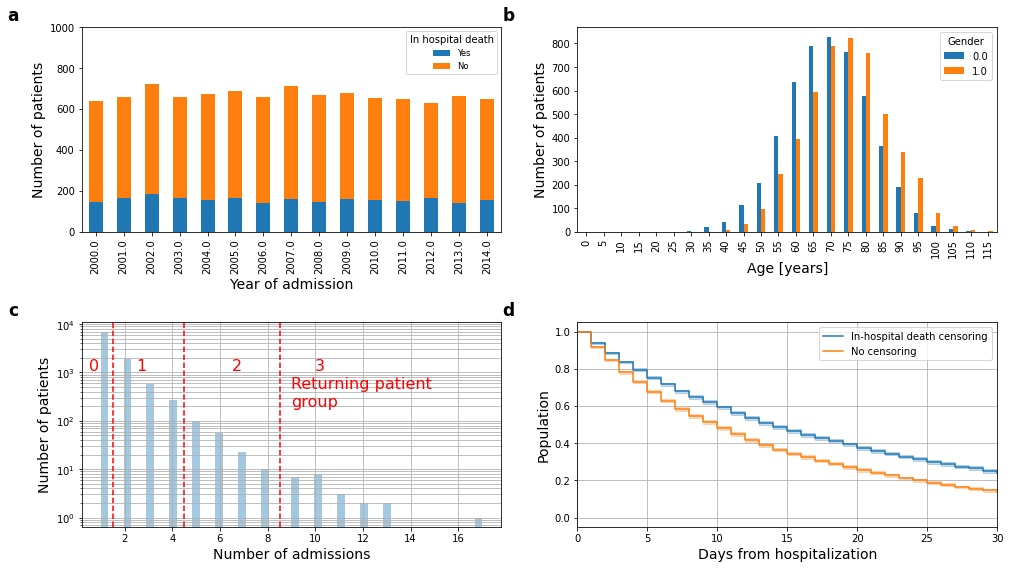

In [15]:
from pydts.examples_utils.plots import *
plot_LOS_simulation_figure1(data_df)

Next, we can further visualize the possible outcomes. At the following figure we can see:

(a) Description of the events (death and release) in the dataset

(b) Age-Gender distributions of the patients who died

(c-d) Events occurrence time  

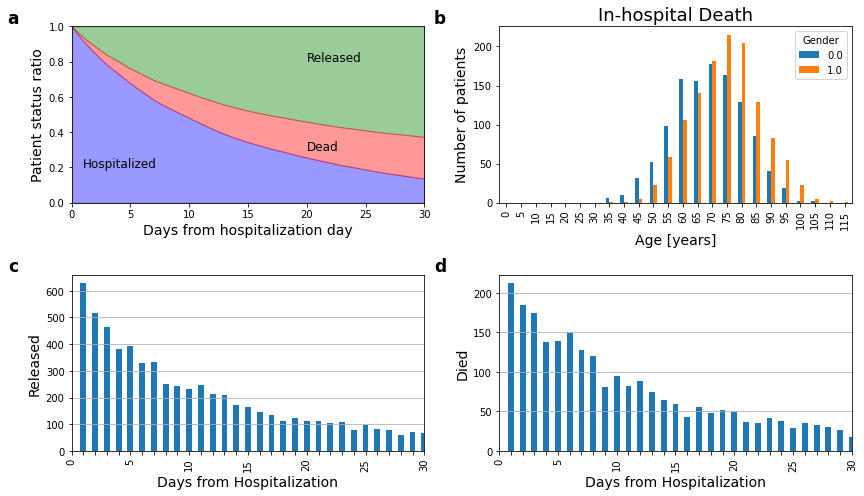

In [6]:
plot_LOS_simulation_figure2(data_df)

and a visualization of the missingness of the weight variable by year of admission:

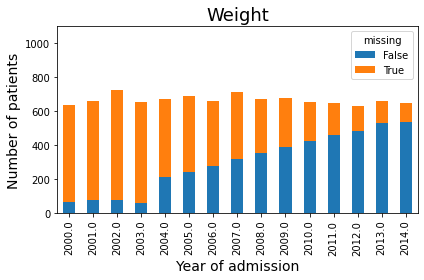

In [7]:
plot_LOS_simulation_figure3(data_df)

# Data Preprocessing

In [8]:
outcome_cols = [
    DISCHARGE_RELATIVE_COL,
    IN_HOSPITAL_DEATH_COL,
    DEATH_RELATIVE_COL, 
    DEATH_MISSING_COL
]

y = data_df.set_index(PATIENT_NO_COL)[outcome_cols]
X = data_df.set_index(PATIENT_NO_COL).drop(columns=outcome_cols)
X.drop([ADMISSION_SERIAL_COL, FIRST_ADMISSION_COL], axis=1, inplace=True)

## Missing Values Imputation

We search for missing data and use median imputation: 

In [9]:
to_impute = X.isna().sum(axis=0).to_frame("value").query("value > 0").index
to_impute

Index(['Weight', 'BMI'], dtype='object')

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(verbose=1, strategy='median')
X[to_impute] = imputer.fit_transform(X[to_impute])

## Normalization

After we imputed the missing data, we normalize the variables. 

For Height, Weight, Age and BMI columns we use Standard scaling, and for Returning Patient and Smoking we use Min-Max scaling:

In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

to_normalize = [HEIGHT_COL, WEIGHT_COL, AGE_COL, BMI_COL]
to_minmax = [RETURNING_PATIENT_COL, SMOKING_COL]

std_scaler = StandardScaler() 
X[to_normalize] = std_scaler.fit_transform(X[to_normalize])

minmax_scaler = MinMaxScaler()
X[to_minmax] = minmax_scaler.fit_transform(X[to_minmax])

X.head()

,Age,Gender,Admyear,Weight,Height,BMI,Smoking,Hypertension,Diabities,AF,COPD,CRF,Returning_patient
ID,,,,,,,,,,,,,
0.0,-0.501435,1.0,2001.0,0.001731,0.198481,-0.010699,0.5,0.0,0.0,0.0,1.0,0.0,0.0
1.0,-1.829968,1.0,2003.0,0.001731,0.255134,-0.010699,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.216468,1.0,2013.0,-0.706832,0.715064,-1.496554,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3.0,0.356748,1.0,2008.0,0.001731,-0.738724,-0.010699,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4.0,-0.509686,0.0,2011.0,0.001731,-0.610285,-0.010699,0.5,1.0,1.0,0.0,0.0,0.0,0.0


We will now create an event time column using the In hospital death column, such that:

In_hospital_death = 1 means in hospital death (J=1)

In_hospital_death = 0 with Discharge_relative_date <= 30 means a discharge event (J=2)

Discharge_relative_date = 31 means right censored example, i.e. (J=0 at T=30)

In [12]:
y.loc[((y.In_hospital_death == 0) & (y.Discharge_relative_date != 31)), IN_HOSPITAL_DEATH_COL] = 2
y[DISCHARGE_RELATIVE_COL].clip(upper=30, inplace=True)
y

,Discharge_relative_date,In_hospital_death,Death_relative_date_in_hosp,Death_date_in_hosp_missing
ID,,,,
0.0,11.0,2,NaN,1
1.0,15.0,2,NaN,1
2.0,6.0,2,NaN,1
3.0,4.0,2,NaN,1
4.0,1.0,1,1.0,0
...,...,...,...,...
9995.0,10.0,1,10.0,0
9996.0,5.0,1,5.0,0
9997.0,1.0,1,1.0,0


## Fit

Now we can fit a TwoStagesFitter to the data:

In [13]:
fit_df = pd.concat([X.drop(ADMISSION_YEAR_COL, axis=1), 
                    y[[IN_HOSPITAL_DEATH_COL, DISCHARGE_RELATIVE_COL]]], axis=1).reset_index()
fit_df.head()

,ID,Age,Gender,Weight,Height,BMI,Smoking,Hypertension,Diabities,AF,COPD,CRF,Returning_patient,In_hospital_death,Discharge_relative_date
0,0.0,-0.501435,1.0,0.001731,0.198481,-0.010699,0.5,0.0,0.0,0.0,1.0,0.0,0.0,2,11.0
1,1.0,-1.829968,1.0,0.001731,0.255134,-0.010699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,15.0
2,2.0,0.216468,1.0,-0.706832,0.715064,-1.496554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,6.0
3,3.0,0.356748,1.0,0.001731,-0.738724,-0.010699,1.0,0.0,1.0,1.0,1.0,0.0,0.0,2,4.0
4,4.0,-0.509686,0.0,0.001731,-0.610285,-0.010699,0.5,1.0,1.0,0.0,0.0,0.0,0.0,1,1.0


In [14]:
from pydts.fitters import TwoStagesFitter
fitter = TwoStagesFitter()
fitter.fit(df=fit_df, event_type_col=IN_HOSPITAL_DEATH_COL, duration_col=DISCHARGE_RELATIVE_COL, 
           pid_col=PATIENT_NO_COL)
fitter.print_summary()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Model summary for event: 1


<lifelines.CoxPHFitter: fitted with 128208 total observations, 125846 right-censored observations>
             duration col = 'Discharge_relative_date'
                event col = 'j_1'
                   strata = Discharge_relative_date_copy
      baseline estimation = breslow
   number of observations = 128208
number of events observed = 2362
   partial log-likelihood = -20115.20
         time fit was run = 2022-04-10 12:09:02 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Age                 0.01       1.01       0.02            -0.03             0.05                 0.97                 1.06
Gender              0.07       1.08       0.05            -0.02             0.17                 0.98                 1.18
Weight             -0.09       0.92       0.04            -0.16            -0.01                 0.85                 0.99
Height             -0.11       0.90       0.03            -0.17            -0.05                 0.85                 0.95
BMI                -0.11       0.89       0.04            -0.19            -0.04                 0.83                 0.96
Smoking             0.01       1.01       0.06            -0.11             0.12                 0.89                 1.13
Hypertension       -0.07       0.94       0.05            -0.17             0.04                 0.84                 1.04
Diabities           0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15
AF                  0.04       1.04       0.05            -0.06             0.14                 0.94                 1.15
COPD                0.03       1.03       0.05            -0.07             0.13                 0.94                 1.13
CRF                 0.02       1.02       0.05            -0.08             0.12                 0.93                 1.13
Returning_patient  -0.10       0.91       0.12            -0.34             0.14                 0.71                 1.15

                      z      p   -log2(p)
covariate                                
Age                0.57   0.57       0.82
Gender             1.49   0.14       2.87
Weight            -2.19   0.03       5.12
Height            -3.78 <0.005      12.65
BMI               -2.99 <0.005       8.47
Smoking            0.10   0.92       0.12
Hypertension      -1.28   0.20       2.31
Diabities          0.99   0.32       1.64
AF                 0.83   0.40       1.30
COPD               0.61   0.54       0.89
CRF                0.48   0.63       0.66
Returning_patient -0.80   0.42       1.24
---
Concordance = 0.56
Partial AIC = 40254.41
log-likelihood ratio test = 127.37 on 12 df
-log2(p) of ll-ratio test = 68.71

n_jt  success  alpha_jt
In_hospital_death Discharge_relative_date                         
1                 1.0                       212     True -3.901826
                  2.0                       184     True -3.950053
                  3.0                       174     True -3.925112
                  4.0                       138     True -4.085360
                  5.0                       139     True -3.992844
                  6.0                       149     True -3.848771
                  7.0                       128     True -3.922036
                  8.0                       120     True -3.908204
                  9.0                        81     True -4.240269
                  10.0                       95     True -4.018168
                  11.0                       82     True -4.095930
                  12.0                       88     True -3.938631
                  13.0                       74     True -4.050635
                  14.0                       65     True -4.108051
                  15.0                       60     True -4.120188
                  16.0                       43     True -4.377010
                  17.0                       56     True -4.067527
                  18.0                       48     True -4.157987
                  19.0                       52     True -4.023369
                  20.0                       49     True -4.016882
                  21.0                       37     True -4.229897
                  22.0                       35     True -4.222299
                  23.0                       42     True -3.979030
                  24.0                       38     True -4.007955
                  25.0                       29     True -4.217928
                  26.0                       36     True -3.923879
                  27.0                       33     True -3.954917
                  28.0                       30     True -3.978909
                  29.0                       27     True -4.023108
                  30.0                       18     True -4.347235



Model summary for event: 2


<lifelines.CoxPHFitter: fitted with 128208 total observations, 121938 right-censored observations>
             duration col = 'Discharge_relative_date'
                event col = 'j_2'
                   strata = Discharge_relative_date_copy
      baseline estimation = breslow
   number of observations = 128208
number of events observed = 6270
   partial log-likelihood = -53438.23
         time fit was run = 2022-04-10 12:09:04 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Age                 0.02       1.02       0.01            -0.01             0.04                 0.99                 1.05
Gender              0.03       1.03       0.03            -0.03             0.09                 0.97                 1.10
Weight             -0.10       0.91       0.02            -0.14            -0.05                 0.87                 0.95
Height             -0.06       0.94       0.02            -0.09            -0.02                 0.91                 0.98
BMI                -0.07       0.93       0.02            -0.12            -0.02                 0.89                 0.98
Smoking            -0.09       0.92       0.04            -0.16            -0.01                 0.85                 0.99
Hypertension        0.02       1.02       0.03            -0.04             0.08                 0.96                 1.09
Diabities           0.03       1.04       0.03            -0.02             0.09                 0.98                 1.09
AF                 -0.01       0.99       0.03            -0.07             0.06                 0.93                 1.06
COPD                0.06       1.06       0.03            -0.00             0.12                 1.00                 1.12
CRF                 0.04       1.04       0.03            -0.02             0.10                 0.98                 1.11
Returning_patient   0.12       1.13       0.07            -0.02             0.27                 0.98                 1.30

                      z      p   -log2(p)
covariate                                
Age                1.43   0.15       2.70
Gender             1.09   0.28       1.85
Weight            -3.99 <0.005      13.90
Height            -3.20 <0.005       9.50
BMI               -3.00 <0.005       8.51
Smoking           -2.32   0.02       5.63
Hypertension       0.69   0.49       1.03
Diabities          1.23   0.22       2.21
AF                -0.18   0.85       0.23
COPD               1.93   0.05       4.22
CRF                1.28   0.20       2.31
Returning_patient  1.67   0.09       3.40
---
Concordance = 0.55
Partial AIC = 106900.47
log-likelihood ratio test = 195.28 on 12 df
-log2(p) of ll-ratio test = 114.65

n_jt  success  alpha_jt
In_hospital_death Discharge_relative_date                         
2                 1.0                       628     True -2.755714
                  2.0                       515     True -2.869952
                  3.0                       466     True -2.889717
                  4.0                       383     True -3.012315
                  5.0                       393     True -2.908478
                  6.0                       330     True -3.011169
                  7.0                       332     True -2.923762
                  8.0                       251     True -3.136989
                  9.0                       242     True -3.104749
                  10.0                      232     True -3.082277
                  11.0                      247     True -2.942857
                  12.0                      215     True -3.012719
                  13.0                      209     True -2.966362
                  14.0                      174     True -3.083501
                  15.0                      163     True -3.082805
                  16.0                      145     True -3.138006
                  17.0                      134     True -3.160356
                  18.0                      111     True -3.290827
                  19.0                      123     True -3.127649
                  20.0                      114     True -3.138881
                  21.0                      112     True -3.090689
                  22.0                      105     True -3.093272
                  23.0                      107     True -3.007764
                  24.0                       77     True -3.276149
                  25.0                       99     True -2.956023
                  26.0                       82     True -3.082226
                  27.0                       80     True -3.037766
                  28.0                       59     True -3.280251
                  29.0                       73     True -2.997231
                  30.0                       69     True -2.985297